In [1]:
import math as mt
import numpy as np
import pandas as pd
import re
import requests
import warnings
from bs4 import BeautifulSoup
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
from datetime import datetime, timedelta
from io import StringIO
import calendar
import json

# Вимкнути попередження FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [2]:
# Список URL-ів
urls_s = [
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D0%B0%D1%82%D0%B0%D0%BA_%D0%91%D0%BF%D0%9B%D0%90_Shahed_136_%D1%83_2022_%D1%80%D0%BE%D1%86%D1%96', #2022
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D0%B0%D1%82%D0%B0%D0%BA_%D0%91%D0%BF%D0%9B%D0%90_Shahed_136_%D1%83_2023_%D1%80%D0%BE%D1%86%D1%96', #2023
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D0%B0%D1%82%D0%B0%D0%BA_%D0%91%D0%BF%D0%9B%D0%90_Shahed_136_%D1%83_2024_%D1%80%D0%BE%D1%86%D1%96', #2024
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D0%B0%D1%82%D0%B0%D0%BA_%D0%91%D0%BF%D0%9B%D0%90_Shahed_136_%D1%83_2025_%D1%80%D0%BE%D1%86%D1%96', #2025
    # Додайте інші URL-и за потреби
]

# Створення списку для об'єктів BeautifulSoup та HTTP-запитів
responses = []
soups = []

# Виконання HTTP-запитів та створення об'єктів BeautifulSoup
for url in urls_s:
    response = requests.get(url)
    responses.append(response)
    soups.append(BeautifulSoup(response.text, 'html.parser'))

def clean_table(table_html):
    table_str = str(table_html)
    return BeautifulSoup(table_str, 'html.parser')

# Функція для отримання DataFrame з вмісту таблиці
def get_dataframe(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    tables = soup.find_all('table', {'class': 'sortable wikitable vatop'})

    cleaned_tables = [clean_table(tables[i]) for i in range(1, len(tables))]

    # Повертаємо список DataFrame з цих таблиць
    return [pd.read_html(StringIO(str(table)))[0] for table in cleaned_tables]

# Отримання даних для кожного URL-у та створення DataFrame
dataframes_s = [get_dataframe(url) for url in urls_s]

# Об'єднання кожного списку DataFrame у свій власний DataFrame
df_s = pd.concat([df for df_list in dataframes_s for df in df_list], ignore_index=True)

In [3]:
#df_s = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14,df15,df16,df17,df18,df19,df20])
df_s['дата'] = df_s['дата'].str.replace(r'.23', '.2023', regex=False)
df_s['дата'] = df_s['дата'].str.replace(r'.24', '.2024', regex=False)
df_s['дата'] = df_s['дата'].str.replace(r'.25', '.2025', regex=False)

df_s = df_s.reset_index(drop = True)

df_s.iat[369,3] = 35
df_s.iat[370,3] = 35
df_s.iat[371,3] = 35

# Вставка нових рядків
new_rows = pd.DataFrame({'дата': ['08.01.2023', '14.01.2023', '20.01.2023', '31.01.2023', '05.01.2023'],
                         'регіон': ['Україна', 'Україна', 'Україна', 'Україна', 'Україна'],
                         'місце': ['Україна', 'Україна', 'Україна', 'Україна', 'Україна'],
                         'всього': [1, 1, 1,1,1],
                         'влучань': [0, 0, 0,0,0],
                         'влучання': ['—', '—', '—', '—', '—'],
                         'жертви': ['—','—', '—', '—', '—']})

# Вставка нових рядків між 78-м та 79-м рядками
df_s = pd.concat([df_s.iloc[:79], new_rows, df_s.iloc[79:]]).reset_index(drop=True)

new_rows2 = pd.DataFrame({'дата': ['26.11.2022', '01.12.2022'],
                         'регіон': ['Україна', 'Україна'],
                         'місце': ['Україна', 'Україна'],
                         'всього': [1, 1],
                         'влучань': [0, 0],
                         'влучання': ['—', '—'],
                         'жертви': ['—','—']})

# Вставка нових рядків між 55-м та 56-м рядками
df_s = pd.concat([df_s.iloc[:56], new_rows2, df_s.iloc[56:]]).reset_index(drop=True)

#df_s

In [4]:
shahed=df_s.rename(columns = {'дата': 'date', 'регіон':'region', 'місце':'city', 'всього':'launched', 'влучань':'impacts', 'влучання':'details', 'жертви':'casualties'})
shahed.set_index('date')

shahed['impacts'] = shahed['impacts'].str.replace('<', '', regex=True)
shahed['impacts'] = shahed['impacts'].astype(str)
shahed['launched'] = shahed['launched'].astype(str)

def replace_plus(match):
    number = int(match.group(1))
    return str(number + 1)

# Застосування регулярного виразу до стовпця
shahed['launched'] = shahed['launched'].apply(lambda x: re.sub(r'(\d+)\+', replace_plus, x))
shahed['impacts'] = shahed['impacts'].apply(lambda x: re.sub(r'(\d+)\+', replace_plus, x))
shahed['launched'] = shahed['launched'].str.replace(r'\[\d+\]', '', regex=True)
shahed['impacts'] = shahed['impacts'].str.replace(r'\[\d+\]', '', regex=True)
shahed['details'] = shahed['details'].str.replace(r'\[\d+\]', '', regex=True)
shahed['region'] = shahed['region'].str.replace(r'\[\d+\]', '', regex=True)
shahed['city'] = shahed['city'].str.replace(r'\[\d+\]', '', regex=True)

shahed.launched = shahed.launched.replace({'—':'0'})
shahed.launched = shahed.launched.fillna(0)
shahed.impacts = shahed.impacts.replace({'—':'0'})

shahed = shahed[shahed['launched'] != "Мобільні вогневі групи протиповітряної оборони за 2 січня знищили 47% безпілотників та 19% крилатих ракет у Північній операційній зоні"]

# Заміна "nan" на 0 перед перетворенням типу даних

shahed.loc[:, 'launched'] = shahed['launched'].astype(int)
shahed.loc[:, 'city'] = shahed['city'].fillna('Невідомо')
shahed['impacts'] = shahed['impacts'].fillna(0)
shahed['impacts'] = pd.to_numeric(shahed['impacts'], errors='coerce', downcast='integer')
shahed['impacts'] = shahed['impacts'].fillna(0).astype(int)
shahed.loc[:, 'casualties'] = shahed['casualties'].replace({'—':'даних про жертв немає'})
shahed.loc[:, 'casualties'] = shahed['casualties'].fillna('даних про жертв немає')
shahed.loc[:, 'details'] = shahed['details'].fillna('не встановлено')
shahed.loc[:, 'details'] = shahed['details'].str.replace(r'^\s+', '', regex=True)
shahed.loc[:, 'region'] = shahed['region'].replace({'—':'Україна'})

replacements_location = {
    'південь': 'Південь',
    'північ': 'Північ',
    'центр': 'Центр',
    'Південь та Центр України': 'Центр та Південь України',
    'схід': 'Схід',
    'захід': 'Захід',
    'Україна (повторна атака)': 'Україна',
    'область': 'обл.'
}

shahed['region'] = shahed['region'].replace(replacements_location, regex=True)
shahed.loc[:, 'details'] = shahed['details'].str.ljust(0)
shahed.loc[:, 'date'] = pd.to_datetime(shahed['date'], format="%d.%m.%Y")
shahed.loc[:, 'intercepted'] = shahed['launched'] - shahed['impacts']
shahed.loc[:, 'missile_type'] = 'Shahed'

new_columns = list(shahed.columns[:3]) + [shahed.columns[-1]] + list(shahed.columns[3:-1])
shahed = shahed[new_columns]

shahed = shahed.drop(['impacts'], axis = 1)
neww_columns = list(shahed.columns[:4]) + list(shahed.columns[5:7]) + [shahed.columns[4]] + [shahed.columns[-1]]
shahed = shahed[neww_columns]

# Групуємо дані за стовпчиком 'date' та застосовуємо функцію для заміни значень
shahed['launched'] = shahed.groupby('date', group_keys=False)['launched'].apply(lambda x: x.mask(x.duplicated(), 0))
shahed['intercepted'] = shahed.groupby('date', group_keys=False)['intercepted'].apply(lambda x: x.mask(x.duplicated(), 0))

shahed.to_csv('/content/drive/MyDrive/Colab Notebooks/shaheds_updated.csv',  encoding='utf-8', index = False)

shahed = shahed.reset_index(drop=True)

shahed = shahed.drop(shahed.index[379])
shahed = shahed.drop(shahed.index[290])
shahed = shahed.drop(shahed.index[286])
shahed = shahed.reset_index(drop=True)

shahed.iat[256,6] = 25
shahed.iat[256,7] = 20
shahed.iat[257,6] = 10
shahed.iat[257,7] = 6
shahed.iat[258,6] = 5
shahed.iat[258,7] = 4
shahed.iat[286,6] = 19
shahed.iat[286,7] = 18
shahed.iat[288,6] = 17
shahed.iat[288,7] = 11
shahed.iat[289,6] = 23
shahed.iat[289,7] = 13


shahed['date'] = pd.to_datetime(shahed['date'])

shahed1 = shahed.copy()
shahed2 = shahed.copy()

shahed

#shahed.head(460)

#shahed.intercepted.sum()
#shahed.launched.sum()

,date,region,city,missile_type,details,casualties,launched,intercepted
0,2022-09-12,Харківська обл.,Куп'янськ,Shahed,"не встановлено, зафіксовано серійний номер: М214",даних про жертв немає,1,1
1,2022-09-15,Дніпропетровська обл.,Нікополь,Shahed,"не встановлено, зафіксовано серійний номер: М229",даних про жертв немає,1,1
2,2022-09-20,Миколаївська обл.,Очаків,Shahed,"інфраструктура порту, зафіксовано серійний ном...",даних про жертв немає,1,0
3,2022-09-22,Миколаївська обл.,Миколаївська обл.,Shahed,Підрозділом 160 ЗРБр було збито одразу чотири ...,даних про жертв немає,4,4
4,2022-09-23,Одеська обл.,Одеса,Shahed,"1 збитий, 2 влучили у адмінбудівлю в припортов...",1 загиблий,3,1
...,...,...,...,...,...,...,...,...
1161,2025-02-18,Кіровоградська обл.,Долинська,Shahed,безпілотник влучив у житлову багатоповерхівку,3 поранено,0,0
1162,2025-02-18,Київ,Київ,Shahed,спалахнула пожежа через уламки,даних про жертв немає,0,0
1163,2025-02-19,"Центр, Південь та Схід України","центр, південь та схід України",Shahed,"106 збиті ППО, ще 56 локаційно втрачено",даних про жертв немає,167,162
1164,2025-02-19,Черкаська обл.,Черкаська обл.,Shahed,"пошкоджено ЛЕП, житло, господарські споруди",даних про жертв немає,0,0


In [5]:
#shahed.loc[shahed['region'] == 'Харківська обл.']
#shahed.head(290)

# Вибір рядків, де значення останнього стовпчика ('останній_стовпець') більше за передостанній ('передостанній_стовпець')
#filtered_rows = shahed[shahed.iloc[:, -1] > shahed.iloc[:, -2]]
#filtered_rows
#plot_shahed
#df_grouped
#shahed.groupby(shahed['date'].dt.to_period('M'))[['launched', 'intercepted']].sum()

In [6]:
shahed_total = shahed[shahed['launched'] != 0]

n = shahed_total.groupby(shahed_total.region)[['launched','intercepted']].sum().sort_values(by = 'launched', ascending = False)
# Видаляємо рядки, де launched = 0 (хоча їх впринципі немає бути)
n = n[n['launched'] != 0].reset_index(drop=True)

n['interc_perc'] = ((n['intercepted'] / n['launched']) * 100).apply(lambda x: round(x, 1))

n.sort_values(by = 'interc_perc', ascending = True, inplace = True)

m = round(((n.intercepted.sum()) / (n.launched.sum()) * 100), 1)
print('ППО України знищують близько', m, '% ворожих шлюхедів.\n')

n.launched.sum()

ППО України знищують близько 92.5 % ворожих шлюхедів.



19256

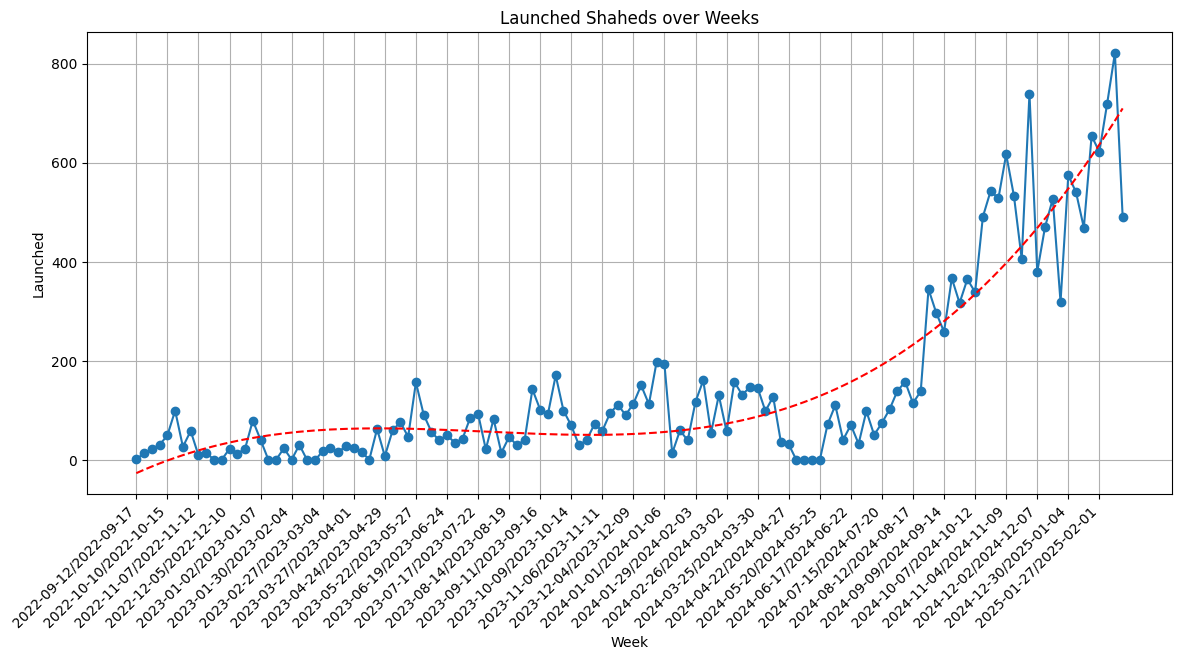

In [7]:
plot_shahed1 = shahed1

# Згрупувати дані по тижнях та обчислити середнє значення 'launched' для кожного тижня
plot_shahed1['week'] = plot_shahed1['date'].dt.to_period('W')
# Групування за тижнями та обчислення суми по стовпцях 'launched' та 'intercepted'
df_grouped = plot_shahed1.groupby('week')[['launched', 'intercepted']].sum().reset_index()
df_grouped['launched'] = df_grouped['launched'].astype(int)
df_grouped['intercepted'] = df_grouped['intercepted'].astype(int)

# Обчислення відсотку перехоплення
df_grouped['interc_perc'] = round((df_grouped['intercepted'] / df_grouped['launched']) * 100, 1)

# Створення діапазону тижнів без пропусків
ideal_weeks = pd.date_range(start="2022-09-12", end=pd.Timestamp.today(), freq='W-MON')

df_grouped['week'] = df_grouped['week'].dt.to_timestamp()

# Перевірка наявності всіх тижнів у df_grouped
missing_weeks = ideal_weeks[~ideal_weeks.isin(df_grouped['week'])]

# Якщо відсутні тижні, додати нові рядки до df_grouped зі значеннями за замовчуванням
if not missing_weeks.empty:
    new_rows = pd.DataFrame({
        'week': missing_weeks,
        'launched': 0,
        'intercepted': 0,
        'interc_perc': 100.0,
        'week_number': range(len(df_grouped) + 1, len(df_grouped) + len(missing_weeks) + 1)
    })
    df_grouped = pd.concat([df_grouped, new_rows]).reset_index(drop=True)

date_format = "%Y-%m-%d"

# Перетворення початкової та кінцевої дат кожного тижня у потрібний формат
df_grouped['week'] = df_grouped['week'].dt.to_period('W-SUN').apply(lambda r: f"{r.start_time.strftime(date_format)}/{(r.end_time - pd.Timedelta(days=1)).strftime(date_format)}")
df_grouped = df_grouped.sort_values('week').reset_index(drop=True)

df_grouped['week_number'] = range(1, len(df_grouped) + 1)

# Побудова лінійного графіка
plt.figure(figsize=(14, 6))  # Задаємо розміри графіка
plt.plot(df_grouped['week_number'], df_grouped['launched'], marker='o', linestyle='-')  # Побудова графіка

week_numbers = df_grouped[df_grouped['week_number'] % 4 == 1]['week_number']  # Вибираємо тижні з першого тижня з кроком 4
week_dates = df_grouped[df_grouped['week_number'] % 4 == 1]['week']  # Вибираємо дати кожного четвертого тижня
plt.xticks(week_numbers, week_dates, rotation=45, ha='right')  # Обертаємо та відображаємо мітки

# Побудова нелінійного тренду (поліном другого степеня)
z = np.polyfit(df_grouped['week_number'], df_grouped['launched'], 3) # ставити 2й степінь полінома (але можна погратись і пошукати інші значення)
p = np.poly1d(z)
plt.plot(df_grouped['week_number'], p(df_grouped['week_number']), "r--")

# Додавання заголовків та підписів до осей
plt.xlabel('Week')
plt.ylabel('Launched')
plt.title('Launched Shaheds over Weeks')

# Відображення сітки на графіку
plt.grid(True)

# Показ графіка
plt.show()

In [8]:
df_ml = df_grouped
df_ml = df_ml.drop(['week'], axis=1)
df_ml = df_ml.drop(['interc_perc'], axis=1)
df_ml = df_ml.drop(['intercepted'], axis=1)
df_ml.set_index('week_number', inplace=True)


df_ml = df_ml.drop(df_ml.index[119]) #видаляю останній тиждень, бо він поки не повний
#df_ml

In [9]:
# Розділення даних на навчальний та тестовий набори
train_size = int(len(df_ml) * 0.99) #цифра вказує на якому куску даних буде вчитись нейронка (0,8-1) самий топ. але графік буде будуватись після навчальної вибірки (!)
train, test = df_ml['launched'][:train_size], df_ml['launched'][train_size:]

# Побудова ARIMA моделі
model1 = ARIMA(train, order=(119,1,0)) #кожен тиждень міняти цифру
#model_fit1 = model1.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


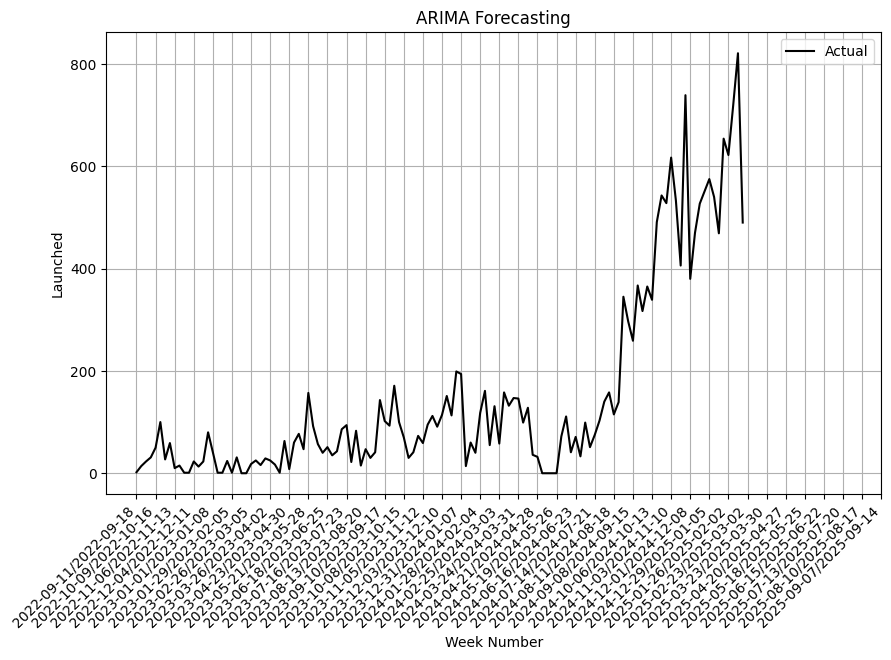

In [10]:
# Прогнозування майбутніх значень
forecast_steps = len(df_ml) - train_size
#forecast = model_fit1.get_forecast(steps=len(df_ml) - 50).predicted_mean #кількість передбачених значень
#forecast = np.maximum(forecast, 0)

# Визначення кінцевої дати - 210 днів після сьогоднішнього дня
end_date = datetime.now() + timedelta(days=210)

# Створення діапазону дат від '2022-09-11' до кінцевої дати
all_dates = pd.date_range(start='2022-09-11', end=end_date)

# Розбиття дат на тижні
weekly_dates = pd.date_range(start=all_dates.min(), end=all_dates.max(), freq='W-SUN')

# Створення змінної для осі x з діапазонами дат у вказаному форматі
x_axis = pd.Series(weekly_dates.strftime('%Y-%m-%d') + '/' + (weekly_dates + pd.DateOffset(days=7)).strftime('%Y-%m-%d'))

# Задаємо кількість тижнів
week_numbers_new = pd.Series(range(1, len(weekly_dates) + 1))

# Фільтруємо мітки осі X кожні 4 тижні
x_axis_quarterly = x_axis[::4]
week_numbers_quarterly = week_numbers_new[::4]

# Виведення графіка з оновленою осі x
plt.figure(figsize=(10, 6))
plt.plot(df_ml.index, df_ml, color='black', label='Actual')
#plt.plot(forecast.index, forecast, color='red', label='Forecast')
plt.xticks(week_numbers_quarterly, x_axis_quarterly, rotation=45, ha='right')  # Обертаємо та відображаємо мітки
plt.legend()
plt.title('ARIMA Forecasting')
plt.xlabel('Week Number')
plt.ylabel('Launched')
plt.grid(True)
plt.show()

In [11]:
shahed_test = shahed1
# Вибираємо стовпці за їхніми позиціями
scolumn_6 = shahed_test.iloc[:, 7]
scolumn_7 = shahed_test.iloc[:, 6]

# Видаляємо стовпчик на позиції 4
shahed_test.drop(columns=['city'], inplace=True)
shahed_test.drop(columns=['launched'], inplace=True)
shahed_test.drop(columns=['intercepted'], inplace=True)
shahed_test.drop(columns=['casualties'], inplace=True)

# Вставляємо стовпці на нові позиції
shahed_test.insert(loc=2, column='intercepted', value=scolumn_6)
shahed_test.insert(loc=3, column='launched', value=scolumn_7)

In [12]:
shahed_test.set_index('date', inplace=True)

In [13]:
shahed_aggregated_df = shahed_test.groupby(['date'])[['region', 'intercepted', 'launched', 'missile_type', 'details']].agg(list).reset_index()

shahed_aggregated_df['intercepted'] = shahed_aggregated_df['intercepted'].astype(str)
shahed_aggregated_df['launched'] = shahed_aggregated_df['launched'].astype(str)

# Функція для розбиття списків на множини та об'єднання множин у рядок
def unique_values_to_string(unique_list):
    return ', '.join(sorted(unique_list))

shahed_aggregated_df['region'].fillna('', inplace=True)
shahed_aggregated_df['intercepted'].fillna('', inplace=True)
shahed_aggregated_df['launched'].fillna('', inplace=True)
shahed_aggregated_df['missile_type'].fillna('', inplace=True)
shahed_aggregated_df['details'].fillna('', inplace=True)

# Застосуємо функцію до кожного стовпчика
shahed_aggregated_df['region'] = shahed_aggregated_df['region'].apply(lambda x: unique_values_to_string(set(x)))

shahed_aggregated_df['intercepted'] = shahed_aggregated_df['intercepted'].replace(r'([^0-9\.]),|,([^0-9])', r'\1\2', regex=True)
shahed_aggregated_df['intercepted'] = shahed_aggregated_df['intercepted'].replace(r', \[\s*\]$|0,|\[|\]', '', regex=True)

shahed_aggregated_df['launched'] = shahed_aggregated_df['launched'].replace('([^0-9]),', value=r'\1', regex=True)
shahed_aggregated_df['launched'] = shahed_aggregated_df['launched'].replace(r'\[|\]', '', regex=True)

shahed_aggregated_df['missile_type'] = shahed_aggregated_df['missile_type'].apply(lambda x: unique_values_to_string(set(x)))
shahed_aggregated_df['details'] = shahed_aggregated_df['details'].apply(lambda x: unique_values_to_string(set(x)))

shahed_aggregated_df['details'] = shahed_aggregated_df['details'].replace(r'^не встановлено, |жертви', r'', regex=True)
shahed_aggregated_df['details'] = shahed_aggregated_df['details'].replace(r',\s+,', r',', regex=True)
shahed_aggregated_df['details'] = shahed_aggregated_df['details'].replace(r'^не встановлено,', r'не встановлено', regex=True)

def replace_with_sum(text):
    # Знаходимо всі числа у тексті
    numbers = [int(num) for num in re.findall(r'\d+', text)]
    # Замінюємо числа на їхню суму
    return str(sum(numbers))

shahed_aggregated_df['intercepted'] = shahed_aggregated_df['intercepted'].apply(replace_with_sum)
shahed_aggregated_df['launched'] = shahed_aggregated_df['launched'].apply(replace_with_sum)

shahed_agg = shahed_aggregated_df


shahed_agg['intercepted'] = shahed_agg['intercepted'].astype(int)
shahed_agg['launched'] = shahed_agg['launched'].fillna(0).astype(int)

#shahed_agg.launched.sum()
#shahed_agg.head(208)
#shahed_agg.details.value_counts()
shahed_agg

,date,region,intercepted,launched,missile_type,details
0,2022-09-12,Харківська обл.,1,1,Shahed,зафіксовано серійний номер: М214
1,2022-09-15,Дніпропетровська обл.,1,1,Shahed,зафіксовано серійний номер: М229
2,2022-09-20,Миколаївська обл.,0,1,Shahed,"інфраструктура порту, зафіксовано серійний ном..."
3,2022-09-22,Миколаївська обл.,4,4,Shahed,Підрозділом 160 ЗРБр було збито одразу чотири ...
4,2022-09-23,"Миколаївська обл., Одеська обл.",1,3,Shahed,"1 збитий, 2 влучили у адмінбудівлю в припортов..."
...,...,...,...,...,...,...
531,2025-02-15,"Центр, Південь та Схід України",70,70,Shahed,"33 збиті ППО, ще 37 локаційно втрачено"
532,2025-02-16,"Київська обл., Миколаївська обл., Центр, Півде...",141,143,Shahed,"95 збиті ППО, ще 46 локаційно втрачено, дрони ..."
533,2025-02-17,"Запорізька обл., Київська обл., Сумська обл., ...",142,147,Shahed,"83 збиті ППО, ще 59 локаційно втрачено, пошкод..."
534,2025-02-18,"Київ, Кіровоградська обл., Полтавська обл., Це...",170,176,Shahed,"103 збиті ППО, ще 67 локаційно втрачено, безпі..."


In [14]:
today = datetime.today()
days_in_month = calendar.monthrange(today.year, today.month)[1]

ukrainian_months = { #у родовому відмінку
    1: "січень", 2: "лютий", 3: "березень", 4: "квітень", 5: "травень", 6: "червень",
    7: "липень", 8: "серпень", 9: "вересень", 10: "жовтень", 11: "листопад", 12: "грудень"
}

shahed_agg['month'] = pd.to_datetime(shahed_agg['date']).dt.to_period('M')
shahed_agg['day'] = pd.to_datetime(shahed_agg['date']).dt.to_period('d')

# Знаходимо місяць із найбільшою кількістю запусків
launch_per_month = shahed_agg.groupby('month')['launched'].sum()
max_month = launch_per_month.idxmax()
max_value = launch_per_month.max()

# Отримуємо номер місяця та рік
month_number = max_month.month
year = max_month.year

# Отримуємо назву місяця українською
month_name = ukrainian_months[month_number]
#==============================================================================================================
last_month_data = shahed_agg[pd.to_datetime(shahed_agg['date']).dt.to_period('M') == '2025-02']

last_sunday = pd.Timestamp.today().normalize() - pd.DateOffset(days=pd.Timestamp.today().weekday() + 1)
last_monday = last_sunday - pd.DateOffset(days=6)

last_week_data = shahed_agg[(shahed_agg['date'] >= last_monday) & (shahed_agg['date'] <= last_sunday)]

# Розраховуємо суму для стовпців "launched" та "intercepted"
total_launched = last_month_data['launched'].sum()
total_intercepted = last_month_data['intercepted'].sum()
#==============================================================================================================
ukrainian_months_d = { #у родовому відмінку
    1: "січня", 2: "лютого", 3: "березня", 4: "квітня", 5: "травня", 6: "червня",
    7: "липня", 8: "серпня", 9: "вересня", 10: "жовтня", 11: "листопада", 12: "грудня"
}

# Знаходимо місяць із найбільшою кількістю запусків
launch_per_day = shahed_agg.groupby('day')['launched'].sum()
max_day = launch_per_day.idxmax()
max_value_day = launch_per_day.max()
# Отримуємо номер місяця та рік
day_number = max_day.day
month_number_d = max_day.month
year_d = max_day.year
month_name_d = ukrainian_months_d[month_number_d]
#==============================================================================================================
today_d = pd.Timestamp.today().normalize()
today_data_l = (shahed_agg[(shahed_agg['date'] == today_d)]).launched.max()
today_data_i = (shahed_agg[(shahed_agg['date'] == today_d)]).intercepted.max()

In [15]:
print('=============СТАТИСТИКА===============\n')
print("Сума запущених дронів за останній місяць:", total_launched)
print("Сума дронів, що не досягли цілі за останній місяць:", total_intercepted)
print("Ефективність ППО за минулий місяць:", (total_intercepted/total_launched).round(4)*100, '%')
print("Сума запущених дронів за минулий тиждень:", last_week_data['launched'].sum(), '\n')
print('==============РЕКОРДИ================\n')
print(f"Рекордним місяцем за кількістю запусків був {month_name} {year} року і становить {max_value} дронів.")
print(f"Рекордним днем за кількістю запусків було {day_number}-е {month_name_d} {year_d} року і становить {max_value_day} дронів.\n")
print('==============ПРОГНОЗ================\n')
print("Очікувана кількість запущених дронів за місяць (за умови збереження тенденції):", (total_launched/last_month_data.date.max().day*days_in_month).astype(int), '\n') #прогноз від 17.02.2025 на кількість дронів в місяць = 3071

=============СТАТИСТИКА===============

Сума запущених дронів за останній місяць: 2208
Сума дронів, що не досягли цілі за останній місяць: 2140
Ефективність ППО за минулий місяць: 96.92 %
Сума запущених дронів за минулий тиждень: 821 

==============РЕКОРДИ================

Рекордним місяцем за кількістю запусків був січень 2025 року і становить 2599 дронів.
Рекордним днем за кількістю запусків було 13-е грудня 2024 року і становить 193 дронів.

==============ПРОГНОЗ================

Очікувана кількість запущених дронів за місяць (за умови збереження тенденції): 3253 



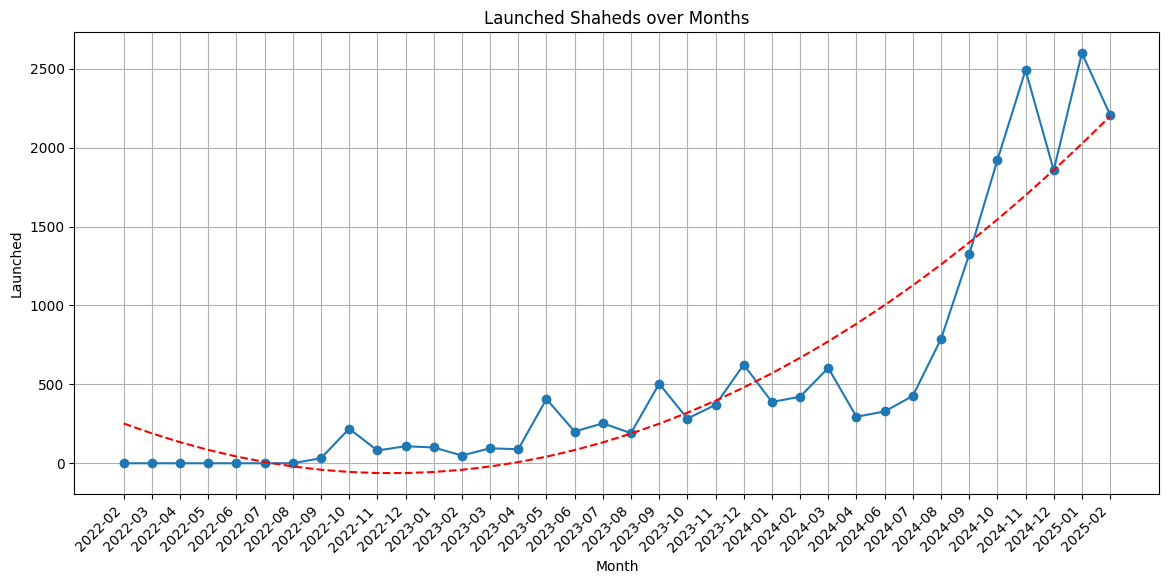

In [16]:
# Видалення рядків, де значення в стовпці 'launched' дорівнює 0
plot_shahed2 = shahed2[shahed2['launched'] != 0]
plot_shahed2 = plot_shahed2.reset_index(drop=True)

# Згрупувати дані по місяцях та обчислити середнє значення 'launched' для кожного місяця
plot_shahed2['month'] = plot_shahed2['date'].dt.to_period('M')
# Групування за місяцями та обчислення суми по стовпцях 'launched' та 'intercepted'
df_grouped = plot_shahed2.groupby('month')[['launched', 'intercepted']].sum().reset_index()
df_grouped['launched'] = df_grouped['launched'].astype(int)
df_grouped['intercepted'] = df_grouped['intercepted'].astype(int)

# Обчислення відсотку перехоплення
df_grouped['interc_perc'] = round((df_grouped['intercepted'] / df_grouped['launched']) * 100, 1)
new_rows_s = pd.DataFrame({'month': ['2022-02', '2022-03','2022-04', '2022-05','2022-06', '2022-07','2022-08'],
                           'launched': [0,0,0,0,0,0,0],
                           'intercepted': [0,0,0,0,0,0,0],
                           'interc_perc': [0,0,0,0,0,0,0],
                           'month_number': [0,0,0,0,0,0,0]})

df_grouped = pd.concat([new_rows_s, df_grouped], ignore_index=True)


# Перерахунок значень month_number
df_grouped['month_number'] = range(1, len(df_grouped) + 1)

# Побудова лінійного графіка
plt.figure(figsize=(14, 6))  # Задаємо розміри графіка
plt.plot(df_grouped['month_number'], df_grouped['launched'], marker='o', linestyle='-')  # Побудова графіка

month_numbers = df_grouped['month_number']
month_dates = df_grouped['month']
plt.xticks(month_numbers, month_dates, rotation=45, ha='right')  # Обертаємо та відображаємо мітки

# Побудова нелінійного тренду (поліном другого степеня)
z = np.polyfit(df_grouped['month_number'], df_grouped['launched'], 2) # ставити 2й степінь полінома (але можна погратись і пошукати інші значення)
p = np.poly1d(z)
plt.plot(df_grouped['month_number'], p(df_grouped['month_number']), "r--")

# Додавання заголовків та підписів до осей
plt.xlabel('Month')
plt.ylabel('Launched')
plt.title('Launched Shaheds over Months')

# Відображення сітки на графіку
plt.grid(True)

# Показ графіка
plt.show()


# Знизу поки шо РОБОЧА дроч з ракетами

In [17]:
# Список URL-ів
urls = [
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D1%80%D0%B0%D0%BA%D0%B5%D1%82%D0%BD%D0%B8%D1%85_%D1%83%D0%B4%D0%B0%D1%80%D1%96%D0%B2_%D0%BF%D1%96%D0%B4_%D1%87%D0%B0%D1%81_%D1%80%D0%BE%D1%81%D1%96%D0%B9%D1%81%D1%8C%D0%BA%D0%BE%D0%B3%D0%BE_%D0%B2%D1%82%D0%BE%D1%80%D0%B3%D0%BD%D0%B5%D0%BD%D0%BD%D1%8F_(%D0%BB%D1%8E%D1%82%D0%B8%D0%B9-%D1%82%D1%80%D0%B0%D0%B2%D0%B5%D0%BD%D1%8C_2022)',
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D1%80%D0%B0%D0%BA%D0%B5%D1%82%D0%BD%D0%B8%D1%85_%D1%83%D0%B4%D0%B0%D1%80%D1%96%D0%B2_%D0%BF%D1%96%D0%B4_%D1%87%D0%B0%D1%81_%D1%80%D0%BE%D1%81%D1%96%D0%B9%D1%81%D1%8C%D0%BA%D0%BE%D0%B3%D0%BE_%D0%B2%D1%82%D0%BE%D1%80%D0%B3%D0%BD%D0%B5%D0%BD%D0%BD%D1%8F_(%D1%87%D0%B5%D1%80%D0%B2%D0%B5%D0%BD%D1%8C-%D1%81%D0%B5%D1%80%D0%BF%D0%B5%D0%BD%D1%8C_2022)',
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D1%80%D0%B0%D0%BA%D0%B5%D1%82%D0%BD%D0%B8%D1%85_%D1%83%D0%B4%D0%B0%D1%80%D1%96%D0%B2_%D0%BF%D1%96%D0%B4_%D1%87%D0%B0%D1%81_%D1%80%D0%BE%D1%81%D1%96%D0%B9%D1%81%D1%8C%D0%BA%D0%BE%D0%B3%D0%BE_%D0%B2%D1%82%D0%BE%D1%80%D0%B3%D0%BD%D0%B5%D0%BD%D0%BD%D1%8F_(%D0%B2%D0%B5%D1%80%D0%B5%D1%81%D0%B5%D0%BD%D1%8C-%D0%BB%D0%B8%D1%81%D1%82%D0%BE%D0%BF%D0%B0%D0%B4_2022)',
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D1%80%D0%B0%D0%BA%D0%B5%D1%82%D0%BD%D0%B8%D1%85_%D1%83%D0%B4%D0%B0%D1%80%D1%96%D0%B2_%D0%BF%D1%96%D0%B4_%D1%87%D0%B0%D1%81_%D1%80%D0%BE%D1%81%D1%96%D0%B9%D1%81%D1%8C%D0%BA%D0%BE%D0%B3%D0%BE_%D0%B2%D1%82%D0%BE%D1%80%D0%B3%D0%BD%D0%B5%D0%BD%D0%BD%D1%8F_(%D0%B3%D1%80%D1%83%D0%B4%D0%B5%D0%BD%D1%8C-%D0%BB%D1%8E%D1%82%D0%B8%D0%B9_2023)',
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D1%80%D0%B0%D0%BA%D0%B5%D1%82%D0%BD%D0%B8%D1%85_%D1%83%D0%B4%D0%B0%D1%80%D1%96%D0%B2_%D0%BF%D1%96%D0%B4_%D1%87%D0%B0%D1%81_%D1%80%D0%BE%D1%81%D1%96%D0%B9%D1%81%D1%8C%D0%BA%D0%BE%D0%B3%D0%BE_%D0%B2%D1%82%D0%BE%D1%80%D0%B3%D0%BD%D0%B5%D0%BD%D0%BD%D1%8F_(%D0%B1%D0%B5%D1%80%D0%B5%D0%B7%D0%B5%D0%BD%D1%8C-%D1%82%D1%80%D0%B0%D0%B2%D0%B5%D0%BD%D1%8C_2023)',
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D1%80%D0%B0%D0%BA%D0%B5%D1%82%D0%BD%D0%B8%D1%85_%D1%83%D0%B4%D0%B0%D1%80%D1%96%D0%B2_%D0%BF%D1%96%D0%B4_%D1%87%D0%B0%D1%81_%D1%80%D0%BE%D1%81%D1%96%D0%B9%D1%81%D1%8C%D0%BA%D0%BE%D0%B3%D0%BE_%D0%B2%D1%82%D0%BE%D1%80%D0%B3%D0%BD%D0%B5%D0%BD%D0%BD%D1%8F_(%D1%87%D0%B5%D1%80%D0%B2%D0%B5%D0%BD%D1%8C-%D1%81%D0%B5%D1%80%D0%BF%D0%B5%D0%BD%D1%8C_2023)',
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D1%80%D0%B0%D0%BA%D0%B5%D1%82%D0%BD%D0%B8%D1%85_%D1%83%D0%B4%D0%B0%D1%80%D1%96%D0%B2_%D0%BF%D1%96%D0%B4_%D1%87%D0%B0%D1%81_%D1%80%D0%BE%D1%81%D1%96%D0%B9%D1%81%D1%8C%D0%BA%D0%BE%D0%B3%D0%BE_%D0%B2%D1%82%D0%BE%D1%80%D0%B3%D0%BD%D0%B5%D0%BD%D0%BD%D1%8F_(%D0%B7_%D0%B2%D0%B5%D1%80%D0%B5%D1%81%D0%BD%D1%8F_2023)',
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D1%80%D0%B0%D0%BA%D0%B5%D1%82%D0%BD%D0%B8%D1%85_%D1%83%D0%B4%D0%B0%D1%80%D1%96%D0%B2_%D0%BF%D1%96%D0%B4_%D1%87%D0%B0%D1%81_%D1%80%D0%BE%D1%81%D1%96%D0%B9%D1%81%D1%8C%D0%BA%D0%BE%D0%B3%D0%BE_%D0%B2%D1%82%D0%BE%D1%80%D0%B3%D0%BD%D0%B5%D0%BD%D0%BD%D1%8F_(%D0%B7%D0%B8%D0%BC%D0%B0_2023/2024)',
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D1%80%D0%B0%D0%BA%D0%B5%D1%82%D0%BD%D0%B8%D1%85_%D1%83%D0%B4%D0%B0%D1%80%D1%96%D0%B2_%D0%BF%D1%96%D0%B4_%D1%87%D0%B0%D1%81_%D1%80%D0%BE%D1%81%D1%96%D0%B9%D1%81%D1%8C%D0%BA%D0%BE%D0%B3%D0%BE_%D0%B2%D1%82%D0%BE%D1%80%D0%B3%D0%BD%D0%B5%D0%BD%D0%BD%D1%8F_(%D0%B2%D0%B5%D1%81%D0%BD%D0%B0_2024)',
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D1%80%D0%B0%D0%BA%D0%B5%D1%82%D0%BD%D0%B8%D1%85_%D1%83%D0%B4%D0%B0%D1%80%D1%96%D0%B2_%D0%BF%D1%96%D0%B4_%D1%87%D0%B0%D1%81_%D1%80%D0%BE%D1%81%D1%96%D0%B9%D1%81%D1%8C%D0%BA%D0%BE%D0%B3%D0%BE_%D0%B2%D1%82%D0%BE%D1%80%D0%B3%D0%BD%D0%B5%D0%BD%D0%BD%D1%8F_(%D0%BB%D1%96%D1%82%D0%BE_2024)',
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D1%80%D0%B0%D0%BA%D0%B5%D1%82%D0%BD%D0%B8%D1%85_%D1%83%D0%B4%D0%B0%D1%80%D1%96%D0%B2_%D0%BF%D1%96%D0%B4_%D1%87%D0%B0%D1%81_%D1%80%D0%BE%D1%81%D1%96%D0%B9%D1%81%D1%8C%D0%BA%D0%BE%D0%B3%D0%BE_%D0%B2%D1%82%D0%BE%D1%80%D0%B3%D0%BD%D0%B5%D0%BD%D0%BD%D1%8F_(%D0%BE%D1%81%D1%96%D0%BD%D1%8C_2024)',
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D1%80%D0%B0%D0%BA%D0%B5%D1%82%D0%BD%D0%B8%D1%85_%D1%83%D0%B4%D0%B0%D1%80%D1%96%D0%B2_%D0%BF%D1%96%D0%B4_%D1%87%D0%B0%D1%81_%D1%80%D0%BE%D1%81%D1%96%D0%B9%D1%81%D1%8C%D0%BA%D0%BE%D0%B3%D0%BE_%D0%B2%D1%82%D0%BE%D1%80%D0%B3%D0%BD%D0%B5%D0%BD%D0%BD%D1%8F_(%D0%B7%D0%B8%D0%BC%D0%B0_2024/2025)'
    # Додайте інші URL-и за потреби
]

# Створення списку для об'єктів BeautifulSoup та HTTP-запитів
responses = []
soups = []

# Виконання HTTP-запитів та створення об'єктів BeautifulSoup
for url in urls:
    response = requests.get(url)
    responses.append(response)
    soups.append(BeautifulSoup(response.text, 'html.parser'))

# Чистка таблиць від дублікатів за допомогою регулярних виразів
def clean_table(table_html):
    table_str = str(table_html)
    cleaned_table = re.sub(r'<td\s+(colspan="\d+"\s+)?rowspan="\d+">(\d+)/(\d+)(\n</td>)?', r'<td>\2/\3\4</td>', table_str)
    cleaned_table = re.sub(r'<td\s+rowspan="\d+">(\d+)/(\d+)\n</td>', r'<td>\1/\2\n</td>', cleaned_table)
    cleaned_table = re.sub(r'<td\s+rowspan="\d+">(\d+)/(\d+)', r'<td>\1/\2', cleaned_table)
    return BeautifulSoup(cleaned_table, 'html.parser')

# Функція для отримання DataFrame з вмісту таблиці
def get_dataframe(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    tables = soup.find_all("table", {"class": "wikitable"})

    # Вибираємо таблиці з індексами 1, 2, 3 та 4, якщо вони доступні
    if len(tables) >= 4:
        cleaned_tables = [clean_table(tables[i]) for i in range(1, min(5, len(tables)))]
    elif len(tables) >= 3:
        cleaned_tables = [clean_table(tables[i]) for i in range(1, min(4, len(tables)))]
    else:
        cleaned_tables = [clean_table(tables[1])]  # Якщо немає таблиць з індексами 2, 3 або 4, то вибираємо тільки таблицю з індексом 1

    # Обробляємо таблиці та створюємо DataFrame
    dataframes = []
    for table in cleaned_tables:
        table_html = str(table)
        # Використовуємо StringIO для сумісності з pd.read_html
        dataframes.append(pd.read_html(StringIO(table_html))[0])

    return dataframes

# Отримання даних для кожного URL-у та створення DataFrame
dataframes = [get_dataframe(url) for url in urls]

# Об'єднання кожного списку DataFrame у свій власний DataFrame
df_m = pd.concat([df for df_list in dataframes for df in df_list], ignore_index=True)

In [18]:
# Об'єднання усіх DataFrame усередині списку
#df_m = pd.concat(concatenated_dataframes, ignore_index=True)

df_m.columns = df_m.columns.droplevel(0)
df_m = df_m.reset_index()
df_m.columns.values[0:5] = 'Нова_назва'
df_m = df_m.drop(['Нова_назва'], axis=1)
df_m.columns.values[2] = 'Нова_назва'
df_m = df_m.drop(['Нова_назва'], axis=1)
df_m.columns.values[3] = 'тип ракети'
df_m.columns.values[4] = 'подробиці'

# Фільтрація даних
df_m = df_m.loc[df_m['дата'] != 'дата не встановлена']
df_m = df_m.dropna(subset=df_m.columns[1:6], how='all')
df_m = df_m.reset_index()
df_m = df_m.drop(['index'], axis=1)

# Копіювання даних зі стовпчика 9 в стовпчик 3 (рядки 670-733)
df_m.iloc[689:732, 3] = df_m.iloc[689:732, 9]
df_m.iloc[956:981, 1] = df_m.iloc[956:981, 11]
df_m.iloc[1078:1175, 1] = df_m.iloc[1078:1175, 11]
df_m.iloc[1078:1175, 4] = df_m.iloc[1078:1175, 12]

df_m = df_m.reset_index()
df_m = df_m.drop(['index'], axis=1)

df_m.columns.values[5:14] = 'Нова_назва'
df_m = df_m.drop(['Нова_назва'], axis=1)

df_m['подробиці'] = df_m['подробиці'].str.replace(r'\[\d+\]', '', regex=True)
df_m['ракети'] = df_m['ракети'].str.replace(r'\[\d+\]', '', regex=True)
df_m['регіон'] = df_m['регіон'].str.replace(r'\[\d+\]', '', regex=True)
df_m['тип ракети'] = df_m['тип ракети'].str.replace(r'\[\d+\]', '', regex=True)

df_m = df_m.dropna(subset=df_m.columns[1:6], how='all')
df_m = df_m.drop(df_m.loc[df_m['ракети'] == '—'].index)
df_m = df_m.reset_index(drop=True)

df_m

,дата,регіон,ракети,тип ракети,подробиці
0,24.02.2022,Львівська обл.,0/3,Калібр,"військова інфраструктура, жертви: 0/1"
1,24.02.2022,Львівська обл.,0/2+,Калібр,"військова інфраструктура, жертви: 0/1"
2,24.02.2022,Львівська обл.,0/5,Калібр,"військова інфраструктура, жертви: 0/1"
3,24.02.2022,Івано-Франківська обл.,0/4,Калібр,склад ПММ
4,24.02.2022,Івано-Франківська обл.,0/2,Калібр,"військовий аеродром, жертви: 0/5"
...,...,...,...,...,...
1443,12.02.2025,Київська обл.,не встановлено,Іскандер-М,NaN
1444,12.02.2025,Миколаївська обл.,1/1,Х-35,ракета вийшла з ладу
1445,13.02.2025,Одеська обл.,0/1,—,атаковано припортову інфраструктуру
1446,17.02.2025,Чернігівська обл.,1/1,Х-59,перехоплено українською ППО


In [19]:
# спочатку перейменовувати, потім видаляти
df_m.iat[170,2] = '1/3'
df_m.iat[418,1] = 'Україна'
df_m.iat[452,1] = 'Україна'
df_m.iat[458,1] = 'Центр, Північ'
df_m.iat[486,1] = 'Центр, Захід'
df_m.iat[500,0] = '29.01.2023'
df_m.iat[501,0] = '29.01.2023'
df_m.iat[502,0] = '29.01.2023'
df_m.iat[505,1] = 'Україна'
df_m.iat[511,1] = 'Центр, Захід'
df_m.iat[521,0] = '15.02.2023'
df_m.iat[528,1] = 'Україна'
df_m.iat[593,1] = 'Центр, Схід'
df_m.iat[647,2] = '1/3'
df_m.iat[659,1] = 'Захід'
df_m.iat[679,1] = 'Київ, Черкаси, Захід'
df_m.iat[695,1] = 'Південь'
df_m.iat[786,1] = 'Центр, Північ'
df_m.iat[797,2] = '1/3'
df_m.iat[799,1] = 'Центр, Північ'
df_m.iat[818,1] = 'Україна'
df_m.iat[828,1] = 'Україна'
df_m.iat[901,1] = 'Україна'
df_m.iat[909,1] = 'Київ, Львів'
df_m.iat[950,1] = 'Україна'

# Виберемо рядки, які починаються на "число/число"
mask = df_m['ракети'].str.match(r'^\d+/\d+')

# Застосуємо маску до DataFrame, щоб залишити тільки відповідні рядки
df_m = df_m[mask.astype(bool)]
df_m = df_m.reset_index(drop=True)
df_m

,дата,регіон,ракети,тип ракети,подробиці
0,24.02.2022,Львівська обл.,0/3,Калібр,"військова інфраструктура, жертви: 0/1"
1,24.02.2022,Львівська обл.,0/2+,Калібр,"військова інфраструктура, жертви: 0/1"
2,24.02.2022,Львівська обл.,0/5,Калібр,"військова інфраструктура, жертви: 0/1"
3,24.02.2022,Івано-Франківська обл.,0/4,Калібр,склад ПММ
4,24.02.2022,Івано-Франківська обл.,0/2,Калібр,"військовий аеродром, жертви: 0/5"
...,...,...,...,...,...
1294,12.02.2025,Київ,6/7,Іскандер-М,"пошкоджено житлові та офісні будинки, жертви: 1/4"
1295,12.02.2025,Миколаївська обл.,1/1,Х-35,ракета вийшла з ладу
1296,13.02.2025,Одеська обл.,0/1,—,атаковано припортову інфраструктуру
1297,17.02.2025,Чернігівська обл.,1/1,Х-59,перехоплено українською ППО


***ДОКИДАЮ В ОБЩАК, ДЕ НЕМАЄ КОНКРЕТИКИ***

In [20]:
#відповідно до даних у ВІКІ
new_rows_m = pd.DataFrame({'дата': ['24.02.2022','31.03.2022','30.04.2022','31.05.2022','30.06.2022','31.07.2022','31.08.2022','30.09.2022','31.10.2022','30.11.2022','31.12.2022','31.01.2023','28.02.2023','31.03.2023','30.04.2023'],
                         'регіон': ['Україна','Україна','Україна','Україна','Україна','Україна','Україна','Україна','Україна','Україна','Україна','Україна','Україна','Україна','Україна'],
                         'ракети': ['0/31','1/51','3/32','2/24','1/22','0/19','0/17','0/21','0/0','0/0','0/0','0/0','0/2','0/7','0/3'],
                         'тип ракети': ['—','—','—','—','—','—','—','—','—','—','—','—','—','—','—'],
                         'подробиці': ['—','—','—','—','—','—','—','—','—','—','—','—','—','—','—']})
# Вставка нових рядків для квітня 2023 відповідно до даних у ВІКІ
df_m = pd.concat([df_m, new_rows_m])

df_m['дата'] = df_m['дата'].fillna(method = 'ffill')
df_m['дата'] = df_m['дата'].str.replace('\?\?.\?\?.2022', '15.04.2022', regex=True)  # або ж просто видаліть рядок, бо тут нуль інформативної складової
df_m['дата'] = df_m['дата'].str.replace('\?\?', '15', regex=True)  # нехай усі випадки, коли точна дата атаки невідома, це буде 15-им числом місяця
df_m['дата'] = pd.to_datetime(df_m['дата'], format='%d.%m.%Y')

df_m = df_m.sort_values(by='дата')
df_m.reset_index(drop=True, inplace=True)

df_m

,дата,регіон,ракети,тип ракети,подробиці
0,2022-02-24,Львівська обл.,0/3,Калібр,"військова інфраструктура, жертви: 0/1"
1,2022-02-24,Донецька обл.,0/1,Точка-У,не встановлено
2,2022-02-24,Донецька обл.,0/1,Точка-У,"лікарня, жертви: 4/10"
3,2022-02-24,Харківська обл.,0/1,—,"цивільна інфраструктура, жертви: 2/2"
4,2022-02-24,Запорізька обл.,0/2,—,військова інфраструктура
...,...,...,...,...,...
1309,2025-02-12,Миколаївська обл.,1/1,Х-35,ракета вийшла з ладу
1310,2025-02-12,Київ,6/7,Іскандер-М,"пошкоджено житлові та офісні будинки, жертви: 1/4"
1311,2025-02-13,Одеська обл.,0/1,—,атаковано припортову інфраструктуру
1312,2025-02-17,Чернігівська обл.,1/1,Х-59,перехоплено українською ППО


In [21]:
missiles = df_m
# Розділення стовпця на два окремі стовпчики
missiles[['перехоплено', 'запущено']] = missiles['ракети'].str.split('/', expand=True)

# Вибираємо стовпці за їхніми позиціями
column_6 = missiles.iloc[:, 5]
column_7 = missiles.iloc[:, 6]

# Видаляємо стовпчик на позиції 4
missiles.drop(columns=['ракети'], inplace=True)
missiles.drop(columns=['перехоплено'], inplace=True)
missiles.drop(columns=['запущено'], inplace=True)

# Вставляємо стовпці на нові позиції
missiles.insert(loc=2, column='перехоплено', value=column_6)
missiles.insert(loc=3, column='запущено', value=column_7)

missiles_test = missiles


In [22]:
#тестовий кусок для виведення не числових значень у стовпчику ()
#missiles['intercepted_numeric'] = pd.to_numeric(missiles['intercepted'], errors='coerce')
#non_numeric_rows = missiles[missiles['intercepted_numeric'].isna()]
#print(non_numeric_rows)

In [23]:
missiles = missiles_test
missiles = missiles.rename(columns = {'дата': 'date', 'регіон':'region', 'перехоплено':'intercepted', 'запущено':'launched', 'тип ракети':'missile_type', 'подробиці':'hits_and_casulties'})

missiles.region = missiles.region.fillna(method = 'ffill')
missiles.region = missiles.region.fillna('Невідомо')
missiles.missile_type = missiles.missile_type.replace({'—':'Невстановл.'})
missiles.intercepted = missiles.intercepted.replace({'':'0/0'})

missiles[['details', 'casualties']] = missiles['hits_and_casulties'].str.split(pat=':', n=1, expand=True)
missiles = missiles.drop('hits_and_casulties', axis=1)
missiles.details = missiles.details.fillna('не встановлено')
missiles.casualties = missiles.casualties.fillna('даних про жертв немає')
missiles.missile_type = missiles.missile_type.fillna('не встановлено')

missiles.intercepted = missiles.intercepted.fillna(0)
missiles['intercepted'] = missiles['intercepted'].replace('0', 0)
missiles['intercepted'] = missiles['intercepted'].replace('—', 0)

missiles['region'] = missiles['region'].str.replace('область', 'обл.')
missiles['region'] = missiles['region'].str.replace('південь', 'Південь')
missiles['region'] = missiles['region'].str.replace('не встановлено', 'Україна')
missiles['region'] = missiles['region'].str.replace('Суми', 'Сумська обл.')
missiles['region'] = missiles['region'].str.replace(r'схід', 'Схід', regex=True)
missiles['launched'] = missiles['launched'].str.replace('+', '', regex=False)


missiles['missile_type'] = missiles['missile_type'].str.replace(r'не встановлено|0/5|авіаудар', 'невстановлений тип ракети', regex=True)
missiles['missile_type'] = missiles['missile_type'].str.replace(r'48Н6ДМ|48Н6', 'С-300', regex=True)
#missiles['missile_type'] = missiles['missile_type'].str.replace(r'\s', '', regex=True)
missiles['missile_type'] = missiles['missile_type'].str.replace(r'Х-101*', 'Х-101/Х-555/Х-55')

missiles['details'] = missiles['details'].str.replace(r'^\s+', '', regex=True)
missiles['details'] = missiles['details'].str.replace(r'\xa0', ' ', regex=True)

missiles.drop(columns=['casualties'], inplace=True)

missiles = missiles.reset_index(drop=True)

missiles['intercepted'] = missiles['intercepted'].astype(int)

################################################################################
missiles['launched'] = missiles['launched'].astype(str)

def replace_plus(match):
    number = int(match.group(1))
    return str(number + 1)

# Застосування регулярного виразу до стовпця
missiles['launched'] = missiles['launched'].apply(lambda x: re.sub(r'(\d+)\+', replace_plus, x))
missiles['launched'] = missiles['launched'].str.replace(r'None', '0')
################################################################################


missiles['launched'] = pd.to_numeric(missiles['launched'], errors='coerce')
missiles['launched'] = missiles['launched'].fillna(0).astype('Int64')

#missiles['intercepted'].value_counts()
#missiles.loc[missiles['intercepted'] == '2 влучання на територію аеродрому, жертви: 0']

#missiles.to_csv('/content/drive/MyDrive/Colab Notebooks/missiles_updated.csv',  encoding='utf-8', index = False)


#missiles.iloc[700:750]
#missiles.missile_type.value_counts()
#missiles.launched.sum()
#missiles.loc[missiles['date'] == '14.04.2023']

#missiles.loc[missiles['missile_type'] == 'Х-29ТД']
missiles.head(10000)

,date,region,intercepted,launched,missile_type,details
0,2022-02-24,Львівська обл.,0,3,Калібр,"військова інфраструктура, жертви"
1,2022-02-24,Донецька обл.,0,1,Точка-У,не встановлено
2,2022-02-24,Донецька обл.,0,1,Точка-У,"лікарня, жертви"
3,2022-02-24,Харківська обл.,0,1,Невстановл.,"цивільна інфраструктура, жертви"
4,2022-02-24,Запорізька обл.,0,2,Невстановл.,військова інфраструктура
...,...,...,...,...,...,...
1309,2025-02-12,Миколаївська обл.,1,1,Х-35,ракета вийшла з ладу
1310,2025-02-12,Київ,6,7,Іскандер-М,"пошкоджено житлові та офісні будинки, жертви"
1311,2025-02-13,Одеська обл.,0,1,Невстановл.,атаковано припортову інфраструктуру
1312,2025-02-17,Чернігівська обл.,1,1,Х-59,перехоплено українською ППО


In [24]:
#missiles.loc[missiles.details == 'українська ППО знищила 29 із 30 ракет та задіяних в атаці']
#missiles.groupby('region').launched.sum().sort_values(ascending = False)
#missiles.head(30)
#missiles.loc[missiles['missile_type'] == 'Р-37']
#missiles.head(14564564)

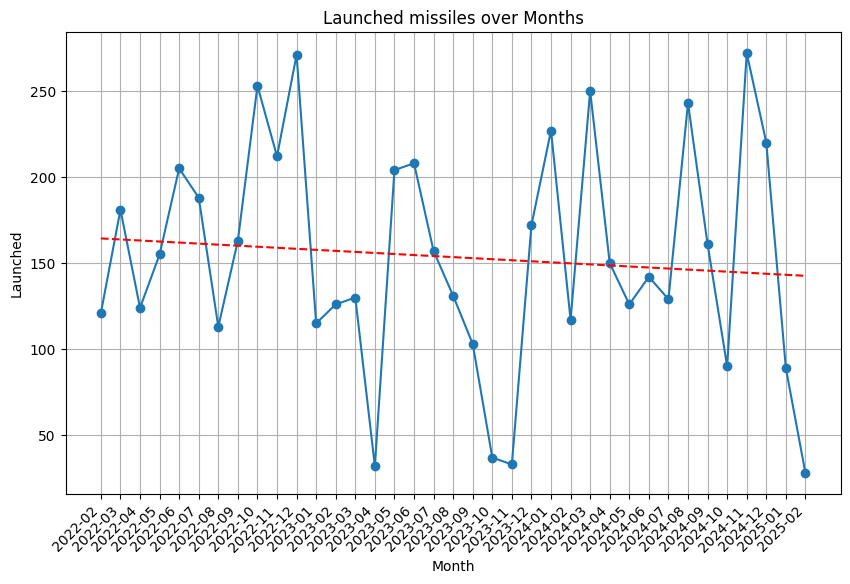

In [25]:
# Видалення рядків, де значення в стовпці 'launched' дорівнює 0
plot_missiles = missiles[missiles['launched'] != 0]
plot_missiles = plot_missiles.reset_index(drop=True)

# Згрупувати дані по місяцях та обчислити середнє значення 'launched' для кожного місяця
plot_missiles['month'] = plot_missiles['date'].dt.to_period('M')
# Групування за місяцями та обчислення суми по стовпцях 'launched' та 'intercepted'
df_grouped_m = plot_missiles.groupby('month')[['launched', 'intercepted']].sum().reset_index()
df_grouped_m['launched'] = df_grouped_m['launched'].astype(int)
df_grouped_m['intercepted'] = df_grouped_m['intercepted'].astype(int)

# Обчислення відсотку перехоплення
df_grouped_m['interc_perc'] = round((df_grouped_m['intercepted'] / df_grouped_m['launched']) * 100, 1)
df_grouped_m['month_number'] = range(1, len(df_grouped_m) + 1)

#df_grouped_m = df_grouped_m.drop(df_grouped_m.index[-1]) #видалення останнього місяця

# Побудова лінійного графіка
plt.figure(figsize=(10, 6))  # Задаємо розміри графіка
plt.plot(df_grouped_m['month_number'], df_grouped_m['launched'], marker='o', linestyle='-')  # Побудова графіка

month_numbers_m = df_grouped_m['month_number']  # Всі номери місяців
month_dates_m = df_grouped_m['month']  # Всі дати місяців
plt.xticks(month_numbers_m, month_dates_m, rotation=45, ha='right')  # Відображаємо мітки

# Побудова нелінійного тренду (поліном другого степеня)
z_m = np.polyfit(df_grouped_m['month_number'], df_grouped_m['launched'], 1)
p_m = np.poly1d(z_m)
plt.plot(df_grouped_m['month_number'], p_m(df_grouped_m['month_number']), "r--")

# Додавання заголовків та підписів до осей
plt.xlabel('Month')
plt.ylabel('Launched')
plt.title('Launched missiles over Months')

# Відображення сітки на графіку
plt.grid(True)

In [26]:
#missiles.loc[missiles['date'] == '2022-12-16']
#a.launched.sum()

In [27]:
missiles.date.value_counts()
missiles_2022 = missiles.loc[missiles['date'] <= '2022-12-31']
missiles_2023 = missiles.loc[(missiles['date'] > '2022-12-31') & (missiles['date'] <= '2023-12-31')]
missiles_2024 = missiles.loc[(missiles['date'] > '2023-12-31') & (missiles['date'] <= '2024-12-31')]
missiles_2025 = missiles.loc[missiles['date'] > '2024-12-31']

In [28]:
missiles.date.value_counts()
a_2022_n = missiles_2022.groupby('region')[['launched', 'intercepted']].sum()
a_2022_n['interc_perc'] = round(((a_2022_n.intercepted / a_2022_n.launched)*100), 1)
a_2022_n.fillna(0, inplace=True)
a_2022_n.sort_values(by = 'launched', ascending = False, inplace = True)

b_2022_n = round(((a_2022_n.intercepted.sum()) / (a_2022_n.launched.sum()) *100), 1)
print('Сили ППО України протягом 2022 року перехопили близько', b_2022_n, '% ворожих ракет.\n')

#a_2022_n.head(20)

Сили ППО України протягом 2022 року перехопили близько 38.3 % ворожих ракет.



In [29]:
a_2023 = missiles_2023.groupby('region')[['launched', 'intercepted']].sum()
a_2023['interc_perc'] = round(((a_2023.intercepted / a_2023.launched)*100), 1)
a_2023.fillna(0, inplace=True)
a_2023.sort_values(by = 'launched', ascending = False, inplace = True)

b_2023 = round(((a_2023.intercepted.sum()) / (a_2023.launched.sum()) *100), 1)
print('Сили ППО України протягом 2023 року перехопили близько', b_2023, '% ворожих ракет.\n')

#a_2023.head(20)

Сили ППО України протягом 2023 року перехопили близько 68.6 % ворожих ракет.



In [30]:
a_2024 = missiles_2024.groupby('region')[['launched', 'intercepted']].sum()
a_2024['interc_perc'] = round(((a_2024.intercepted / a_2024.launched)*100), 1)
a_2024.fillna(0, inplace=True)
a_2024.sort_values(by = 'launched', ascending = False, inplace = True)

b_2024 = round(((a_2024.intercepted.sum()) / (a_2024.launched.sum()) *100), 1)
print('Сили ППО України протягом 2024 року перехопили близько', b_2024, '% ворожих ракет.\n')

#a_2024.head(20)

Сили ППО України протягом 2024 року перехопили близько 57.9 % ворожих ракет.



In [31]:
a_2025 = missiles_2025.groupby('region')[['launched', 'intercepted']].sum()
a_2025['interc_perc'] = round(((a_2025.intercepted / a_2025.launched)*100), 1)
a_2025.fillna(0, inplace=True)
a_2025.sort_values(by = 'launched', ascending = False, inplace = True)

b_2025 = round(((a_2025.intercepted.sum()) / (a_2025.launched.sum()) *100), 1)
print('Сили ППО України протягом 2024 року перехопили близько', b_2025, '% ворожих ракет.\n')

#a_2025.head(20)

Сили ППО України протягом 2024 року перехопили близько 48.7 % ворожих ракет.



In [32]:
a = missiles.groupby('region')[['launched', 'intercepted']].sum()
a['interc_perc'] = round(((a.intercepted / a.launched)*100), 2)
a.fillna(0, inplace=True)
a.sort_values(by = 'launched', ascending = False, inplace = True)

b = round(((a.intercepted.sum()) / (a.launched.sum()) *100), 2)
print('З початку повномасштабного вторгнення засобами ППО України було перехоплено близько', b, '% ворожих ракет.\n')
a.launched.sum()
#a.head(20)

З початку повномасштабного вторгнення засобами ППО України було перехоплено близько 53.56 % ворожих ракет.



5678

In [33]:
aggregated_t = missiles[missiles['missile_type'].str.contains('Х-101')].reset_index(drop=True)
aggregated_t = aggregated_t.groupby(['date'])[['region', 'intercepted',	'launched',	'missile_type',	'details']].agg(list).reset_index()

# Функція для розбиття списків на множини та об'єднання множин у рядок
def unique_values_to_string(unique_list):
    return ', '.join(sorted(unique_list))

aggregated_t['region'] = aggregated_t['region'].apply(lambda x: unique_values_to_string(set(x)))
aggregated_t['intercepted'] = aggregated_t['intercepted'].replace(r'([^0-9\.]),|,([^0-9])', r'\1\2', regex=True)
aggregated_t['intercepted'] = aggregated_t['intercepted'].replace(r', \[\s*\]$|0,|\[|\]', '', regex=True)
aggregated_t['launched'] = aggregated_t['launched'].replace('([^0-9]),', value=r'\1', regex=True)
aggregated_t['launched'] = aggregated_t['launched'].replace(r'\[|\]', '', regex=True)
aggregated_t['missile_type'] = aggregated_t['missile_type'].apply(lambda x: unique_values_to_string(set(x)))
aggregated_t['details'] = aggregated_t['details'].apply(lambda x: unique_values_to_string(set(x)))
aggregated_t['details'] = aggregated_t['details'].replace(r'^не встановлено, |жертви', r'', regex=True)
aggregated_t['details'] = aggregated_t['details'].replace(r',\s+,', r',', regex=True)
aggregated_t['details'] = aggregated_t['details'].replace(r'^не встановлено,', r'не встановлено', regex=True)

def replace_with_sum(numbers):
    return str(sum(numbers))

aggregated_t['intercepted'] = aggregated_t['intercepted'].apply(replace_with_sum).astype(int)
aggregated_t['launched'] = aggregated_t['launched'].apply(replace_with_sum).astype(int)

aggregated_t['interc_perc'] = round(((aggregated_t.intercepted / aggregated_t.launched)*100), 1)
aggregated_t = aggregated_t.drop(['region', 'details'], axis=1)

aggregated_t

,date,intercepted,launched,missile_type,interc_perc
0,2022-04-23,2,4,Х-101/Х-555/Х-55,50.0
1,2022-05-07,0,6,Х-101/Х-555/Х-55,0.0
2,2022-06-26,1,6,Х-101/Х-555/Х-55,16.7
3,2022-07-15,4,8,Х-101/Х-555/Х-55,50.0
4,2022-07-16,0,1,Х-101/Х-555/Х-55,0.0
...,...,...,...,...,...
79,2024-09-04,7,13,"Іскандер-М, Х-47М2, Х-101/Х-555/Х-55",53.8
80,2024-11-13,2,2,Х-101/Х-555/Х-55,100.0
81,2024-11-17,85,101,"Калібр, Х-101/Х-555/Х-55",84.2
82,2024-11-21,6,7,Х-101/Х-555/Х-55,85.7


In [34]:
aggregated_t.intercepted.sum()

1604

**Код нижче суто для того шоб поженити 2 таблиці з індексацією по даті (де вона буде унікальною)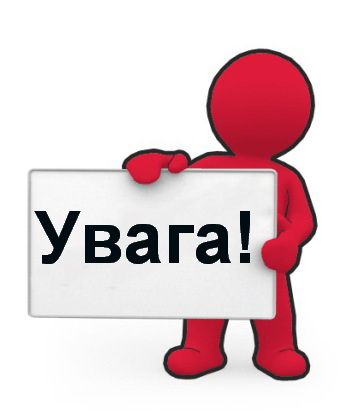**

In [35]:
missiles.set_index('date', inplace=True)

In [36]:
aggregated_df = missiles.groupby(['date'])[['region', 'intercepted',	'launched',	'missile_type',	'details']].agg(list).reset_index()

aggregated_df['intercepted'] = aggregated_df['intercepted'].astype(str)
aggregated_df['launched'] = aggregated_df['launched'].astype(str)

# Функція для розбиття списків на множини та об'єднання множин у рядок
def unique_values_to_string(unique_list):
    return ', '.join(sorted(unique_list))

aggregated_df['region'].fillna('', inplace=True)
aggregated_df['intercepted'].fillna('', inplace=True)
aggregated_df['launched'].fillna('', inplace=True)
aggregated_df['missile_type'].fillna('', inplace=True)
aggregated_df['details'].fillna('', inplace=True)

# Застосуємо функцію до кожного стовпчика
aggregated_df['region'] = aggregated_df['region'].apply(lambda x: unique_values_to_string(set(x)))

aggregated_df['intercepted'] = aggregated_df['intercepted'].replace(r'([^0-9\.]),|,([^0-9])', r'\1\2', regex=True)
aggregated_df['intercepted'] = aggregated_df['intercepted'].replace(r', \[\s*\]$|0,|\[|\]', '', regex=True)

aggregated_df['launched'] = aggregated_df['launched'].replace('([^0-9]),', value=r'\1', regex=True)
aggregated_df['launched'] = aggregated_df['launched'].replace(r'\[|\]', '', regex=True)

aggregated_df['missile_type'] = aggregated_df['missile_type'].apply(lambda x: unique_values_to_string(set(x)))
aggregated_df['details'] = aggregated_df['details'].apply(lambda x: unique_values_to_string(set(x)))

aggregated_df['details'] = aggregated_df['details'].replace(r'^не встановлено, |жертви', r'', regex=True)
aggregated_df['details'] = aggregated_df['details'].replace(r',\s+,', r',', regex=True)
aggregated_df['details'] = aggregated_df['details'].replace(r'^не встановлено,', r'не встановлено', regex=True)

def replace_with_sum(text):
    # Знаходимо всі числа у тексті
    numbers = [int(num) for num in re.findall(r'\d+', text)]
    # Замінюємо числа на їхню суму
    return str(sum(numbers))

aggregated_df['intercepted'] = aggregated_df['intercepted'].apply(replace_with_sum)
aggregated_df['launched'] = aggregated_df['launched'].apply(replace_with_sum)


missiles_agg = aggregated_df

missiles_agg['intercepted'] = missiles_agg['intercepted'].astype(int)
missiles_agg['launched'] = missiles_agg['launched'].fillna(0).astype(int)

#missiles_agg.launched.sum()
#missiles_agg.head(208)
#missiles_agg.details.value_counts()
missiles_agg

,date,region,intercepted,launched,missile_type,details
0,2022-02-24,"Івано-Франківська обл., Волинська обл., Дніпро...",1,73,"Калібр, Невстановл., Точка-У, Х-31","військова інфраструктура, військова інфраструк..."
1,2022-02-25,"Київ, Київська обл., Полтавська обл., Рівненсь...",1,11,"Іскандер, Калібр, Невстановл.","Т-64БВ, БМП-1, аеропорт«Рівне», військовий аер..."
2,2022-02-26,"Житомирська обл., Київ, Сумська обл., Хмельниц...",5,15,Невстановл.,"військова інфраструктура, військовий аеродром,..."
3,2022-02-27,"Житомирська обл., Київ",1,2,"Іскандер, Невстановл.","аеропорт «Житомир», перехоплено українською ППО"
4,2022-02-28,"Київ, Київська обл., Харківська обл.",0,20,"Іскандер, Невстановл.","військова інфраструктура, не встановлено, циві..."
...,...,...,...,...,...,...
685,2025-02-11,Дніпропетровська обл.,0,1,Невстановл.,"пошкоджені АЗС, навчальний заклад, готель, адм..."
686,2025-02-12,"Київ, Миколаївська обл.",7,8,"Іскандер-М, Х-35","пошкоджено житлові та офісні будинки, ракета в..."
687,2025-02-13,Одеська обл.,0,1,Невстановл.,атаковано припортову інфраструктуру
688,2025-02-17,Чернігівська обл.,1,1,Х-59,перехоплено українською ППО


**КОД ДЛЯ ПЕРЕВІРКИ КІЛЬКОСТІ РАКЕТ ПО МІСЯЦЯХ**

In [37]:
from datetime import datetime, timedelta

# Початкова та кінцева дати
start_date = datetime(2022, 2, 24)
end_date = datetime(2024, 5, 14)

# Створення списку дат починаючи з початкової дати і закінчуючи кінцевою датою
dates = []
current_date = start_date
while current_date <= end_date:
    dates.append(current_date)
    current_date += timedelta(days=1)

# Розділення дат на місяці
month_ranges = []
current_month = dates[0].month
start_index = 0
for i, date in enumerate(dates):
    if date.month != current_month:
        month_ranges.append((dates[start_index], dates[i-1]))
        start_index = i
        current_month = date.month
month_ranges.append((dates[start_index], dates[-1]))

# Створення підсумкового DataFrame для місяців
month_summary = pd.DataFrame(columns=['Місяць', 'launched', 'intercepted'])

# Розрахунок суми ракет "launched" та "intercepted" для кожного місяця
for month, (start_date, end_date) in enumerate(month_ranges, start=1):
    month_data = missiles_agg[(missiles_agg['date'] >= start_date) & (missiles_agg['date'] <= end_date)]
    sum_launched = month_data['launched'].sum()
    sum_intercepted = month_data['intercepted'].sum()
    month_summary = pd.concat([month_summary, pd.DataFrame({'Місяць': [month], 'launched': [sum_launched], 'intercepted': [sum_intercepted]})], ignore_index=True)

#print(month_summary)


In [38]:
n_missiles_agg = missiles_agg.rename(columns = {'intercepted':'missiles_intercepted', 'launched':'missiles_launched', 'missile_type':'weapon_type'})
n_shahed_agg = shahed_agg.rename(columns = {'intercepted':'shaheds_intercepted', 'launched':'shaheds_launched', 'missile_type':'weapon_type'})
combined_df = pd.concat([n_missiles_agg, n_shahed_agg], ignore_index=True)

# Вибираємо стовпці за їхніми позиціями
column_6 = combined_df.iloc[:, 6]
column_7 = combined_df.iloc[:, 7]

# Видаляємо стовпчик на позиції 4
combined_df.drop(columns=['shaheds_intercepted'], inplace=True)
combined_df.drop(columns=['shaheds_launched'], inplace=True)

# Вставляємо стовпці на нові позиції
combined_df.insert(loc=3, column='shaheds_intercepted', value=column_6)
combined_df.insert(loc=5, column='shaheds_launched', value=column_7)

combined_df['missiles_intercepted'] = combined_df['missiles_intercepted'].fillna(0).astype(int)
combined_df['missiles_launched'] = combined_df['missiles_launched'].fillna(0).astype(int)
combined_df['shaheds_intercepted'] = combined_df['shaheds_intercepted'].fillna(0).astype(int)
combined_df['shaheds_launched'] = combined_df['shaheds_launched'].fillna(0).astype(int)
# Сортуємо об'єднану таблицю за датою
combined_df = combined_df.sort_values(by='date')
combined_df = combined_df.reset_index(drop=True)

new_aggregated_df = combined_df.groupby(['date'])[['region', 'missiles_intercepted',	'shaheds_intercepted',	'missiles_launched',	'shaheds_launched', 'weapon_type', 'details']].agg(list).reset_index()

new_aggregated_df['missiles_intercepted'] = new_aggregated_df['missiles_intercepted'].astype(str)
new_aggregated_df['shaheds_intercepted'] = new_aggregated_df['shaheds_intercepted'].astype(str)
new_aggregated_df['missiles_launched'] = new_aggregated_df['missiles_launched'].astype(str)
new_aggregated_df['shaheds_launched'] = new_aggregated_df['shaheds_launched'].astype(str)

# Застосуємо функцію до кожного стовпчика
new_aggregated_df['region'] = new_aggregated_df['region'].apply(lambda x: unique_values_to_string(set(x)))

new_aggregated_df['weapon_type'] = new_aggregated_df['weapon_type'].apply(lambda x: unique_values_to_string(set(x)))
new_aggregated_df['details'] = new_aggregated_df['details'].apply(lambda x: unique_values_to_string(set(x)))

new_aggregated_df['details'] = new_aggregated_df['details'].replace(r',\s+,', r',', regex=True)
new_aggregated_df['details'] = new_aggregated_df['details'].replace(r'^не встановлено,', r'не встановлено', regex=True)

new_aggregated_df['missiles_intercepted'] = new_aggregated_df['missiles_intercepted'].apply(replace_with_sum)
new_aggregated_df['shaheds_intercepted'] = new_aggregated_df['shaheds_intercepted'].apply(replace_with_sum)
new_aggregated_df['missiles_launched'] = new_aggregated_df['missiles_launched'].apply(replace_with_sum)
new_aggregated_df['shaheds_launched'] = new_aggregated_df['shaheds_launched'].apply(replace_with_sum)

new_aggregated_df['region'] = new_aggregated_df['region'].apply(lambda x: ', '.join(sorted(set(x.split(', ')))))
new_aggregated_df['weapon_type'] = new_aggregated_df['weapon_type'].apply(lambda x: ', '.join(sorted(set(x.split(', ')))))

new_aggregated_df

new_aggregated_df.to_csv('/content/drive/MyDrive/Colab Notebooks/attacks_updated.csv', encoding='utf-8', index=False, mode='w')
new_aggregated_df.to_excel('/content/drive/MyDrive/Colab Notebooks/attacks_updated.xlsx', index=False)

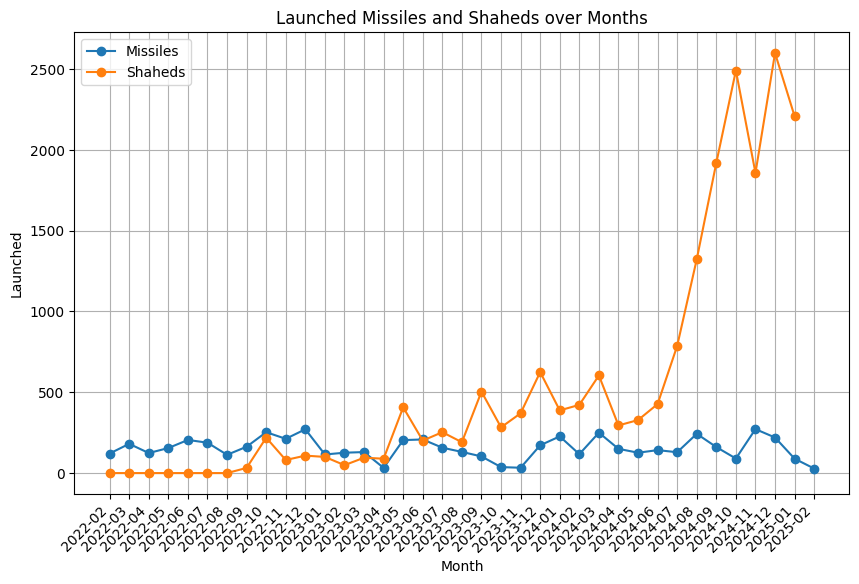

In [39]:
# Побудова лінійного графіка
plt.figure(figsize=(10, 6))  # Задаємо розміри графіка

# Побудова графіка для df_grouped_m
plt.plot(df_grouped_m['month_number'], df_grouped_m['launched'], marker='o', linestyle='-', label='Missiles')
month_numbers_m = df_grouped_m['month_number']  # Всі номери місяців
month_dates_m = df_grouped_m['month']  # Всі дати місяців
plt.xticks(month_numbers_m, month_dates_m, rotation=45, ha='right')  # Відображаємо мітки для df_grouped_m

# Побудова графіка для df_grouped
plt.plot(df_grouped['month_number'], df_grouped['launched'], marker='o', linestyle='-', label='Shaheds')

# Додавання заголовків та підписів до осей
plt.xlabel('Month')
plt.ylabel('Launched')
plt.title('Launched Missiles and Shaheds over Months')

# Додавання легенди
plt.legend()

# Відображення сітки на графіку
plt.grid(True)

# Показ графіка
plt.show()

In [40]:
aggregated_t.tail()

,date,intercepted,launched,missile_type,interc_perc
79,2024-09-04,7,13,"Іскандер-М, Х-47М2, Х-101/Х-555/Х-55",53.8
80,2024-11-13,2,2,Х-101/Х-555/Х-55,100.0
81,2024-11-17,85,101,"Калібр, Х-101/Х-555/Х-55",84.2
82,2024-11-21,6,7,Х-101/Х-555/Х-55,85.7
83,2024-11-28,1,1,Х-101/Х-555/Х-55,100.0


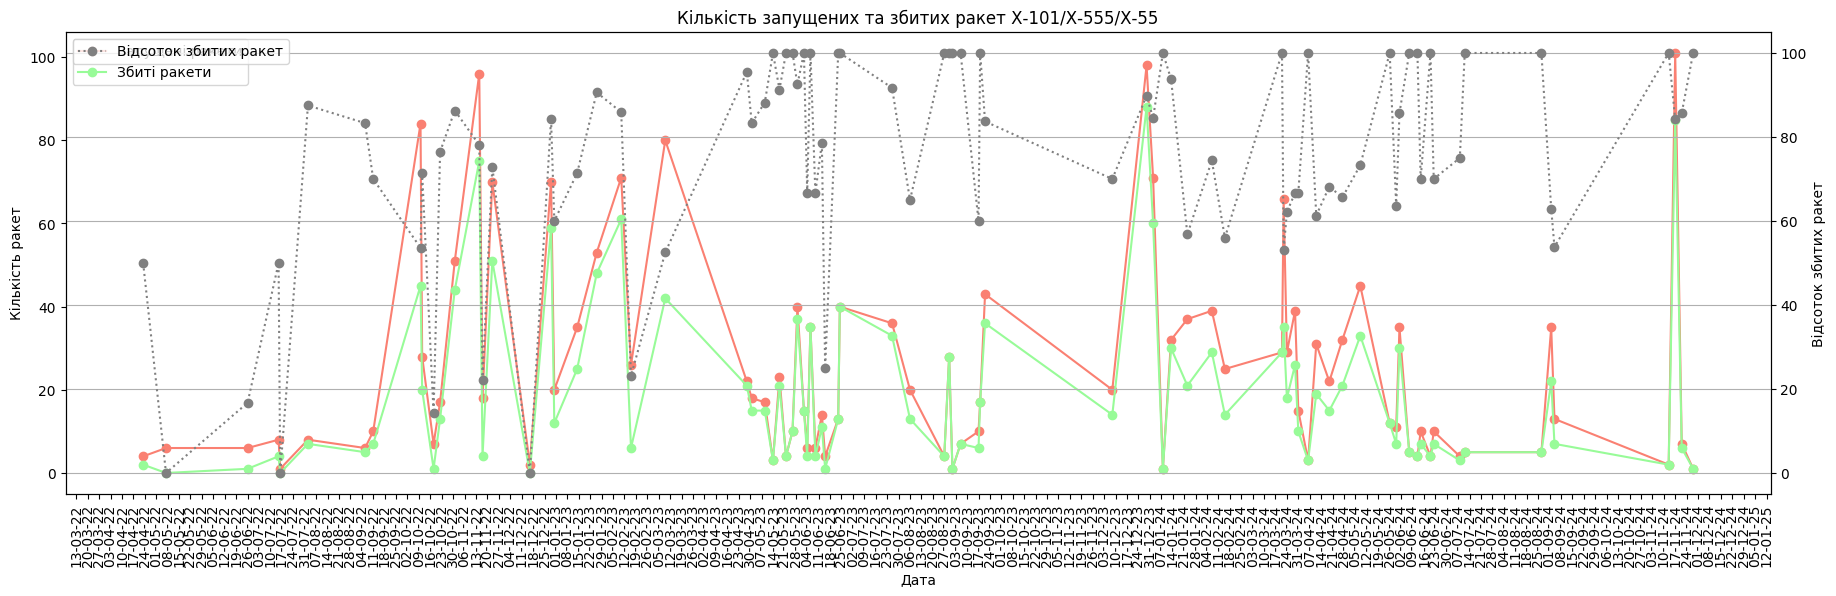

In [41]:
# Створення фігури та осі
fig, ax1 = plt.subplots(figsize=(22, 6))

# Побудова графіків кількості запущених ракет та кількості збитих ракет на основній осі y
ax1.plot(aggregated_t['date'], aggregated_t['launched'], color='salmon', marker='o', linestyle='-', label='Запущені ракети')
ax1.plot(aggregated_t['date'], aggregated_t['intercepted'], color='palegreen', marker='o', linestyle='-', label='Збиті ракети')
ax1.set_xlabel('Дата')
ax1.set_ylabel('Кількість ракет')
ax1.set_title('Кількість запущених та збитих ракет Х-101/Х-555/Х-55')
ax1.tick_params(axis='x', rotation=90)
ax1.legend()

# Створення додаткової осі y для відсотка збитих ракет
ax2 = ax1.twinx()
ax2.plot(aggregated_t['date'], aggregated_t['interc_perc'], color='gray', marker='o', linestyle=':', label='Відсоток збитих ракет')
ax2.set_ylabel('Відсоток збитих ракет')
ax2.legend()

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))  # Встановлюємо формат дати
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))  # Встановлюємо крок в 7 днів для відображення
plt.grid(True)  # Включаємо сітку
plt.show()

In [42]:
!pip install xlsxwriter

# Створюємо ExcelWriter для запису в один файл на різні аркуші
with pd.ExcelWriter('/content/drive/MyDrive/Colab Notebooks/таблички.xlsx', engine='xlsxwriter') as writer:
    shahed_agg.to_excel(writer, sheet_name='Шахеди', index=False)
    missiles_agg.to_excel(writer, sheet_name='Ракети', index=False)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 10.1 MB/s eta 0:00:00


In [43]:
data_json = {
    "stat": {
        "title": "=============СТАТИСТИКА===============",
        "value": ''
    },
    "month_total": {
        "title": "Сума запущених дронів за останній місяць",
        "value": int(total_launched)
    },
    "month_failed": {
        "title": "Сума дронів, що не досягли цілі за останній місяць",
        "value": int(total_intercepted)
    },
    "AD_efficiency": {
        "title": "Ефективність ППО",
        "value": f"{round(total_intercepted / total_launched * 100, 2)}%"
    },
    "week_total": {
        "title": "Сума запущених дронів за минулий тиждень",
        "value": int(last_week_data['launched'].sum())
    },
    "record": {
        "title": "===============РЕКОРДИ=================",
        "value": ''
    },
    "max_month": {
            "title": "Рекордним місяцем за кількістю запусків був",
            "value": f"{month_name} {year}",
            "drones": int(max_value)
    },
    "max_day": {
            "title": "Рекордним днем за кількістю запусків було",
            "value": f"{day_number}-е {month_name_d} {year_d}",
            "drones": int(max_value_day)
    },
    "predict": {
        "title": "===============ПРОГНОЗ=================",
        "value": ''
    },
    "expected_total": {
        "title": "Очікувана кількість запущених дронів за місяць (за умови збереження тенденції)",
        "value": int(total_launched / last_month_data.date.max().day * days_in_month)
    }
}

# Запис у JSON-файл
with open("/content/drive/MyDrive/Colab Notebooks/shaheds_for_alphabot.json", "w", encoding="utf-8") as file:
    json.dump(data_json, file, ensure_ascii=False, indent=2)

In [49]:
dd = (
    "ЗА МИНУЛУ ДОБУ:",
    f"Запущених: {today_data_l}",
    f"Не досягли цілі: {today_data_i}",
    "",
    "ЗА МИНУЛИЙ ТИЖДЕНЬ:",
    f"Запущених: {last_week_data['launched'].sum()}",
    f"Не досягли цілі: {last_week_data['intercepted'].sum()}",
    f"Ефективність ППО: {round(last_week_data['intercepted'].sum() / last_week_data['launched'].sum() * 100, 2)}%",
    "",
    "ЗА ЦЕЙ МІСЯЦЬ:",
    f"Запущених: {total_launched}",
    f"Не досягли цілі: {total_intercepted}",
    f"Ефективність ППО: {round(total_intercepted / total_launched * 100, 2)}%",
    "",
    "РЕКОРДИ:",
    f"Місяць: {month_name} {year} - {max_value} дронів.",
    f"День: {day_number} {month_name_d} {year_d} - {max_value_day} дронів.",
    "",
    "ПРОГНОЗ ПО ЗАПУСКАХ:",
    f"На кінець поточного місяця: {int(total_launched / last_month_data.date.max().day * days_in_month)}",
    "",
    "МУДРІСТЬ ДНЯ:",
    "Хто тримає цей район? Пес Патрон! Пес Патрон!"
)

print("\n".join(dd))

ЗА МИНУЛУ ДОБУ:
Запущених: 167
Не досягли цілі: 162

ЗА МИНУЛИЙ ТИЖДЕНЬ:
Запущених: 821
Не досягли цілі: 799
Ефективність ППО: 97.32%

ЗА МИНУЛИЙ МІСЯЦЬ:
Запущених: 2208
Не досягли цілі: 2140
Ефективність ППО: 96.92%

РЕКОРДИ:
Місяць: січень 2025 - 2599 дронів.
День: 13 грудня 2024 - 193 дронів.

ПРОГНОЗ ПО ЗАПУСКАХ:
На кінець поточного місяця: 3253

МУДРІСТЬ ДНЯ:
Хто тримає цей район? Пес Патрон! Пес Патрон!


In [50]:
with open("/content/drive/MyDrive/Colab Notebooks/shaheds_for_alphabot.txt", "w", encoding="utf-8") as file:
    file.write("\n".join(dd))